In [17]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
import warnings

# Ignore UserWarnings related to librosa.core.audio.__audioread_load
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

In [10]:
# Upload your kaggle.json key file (from Kaggle account > API)
from google.colab import files
try:
    files.upload()   # Select kaggle.json
except:
    print("kaggle.json already uploaded")


!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download GTZAN dataset
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip -d gtzan_dataset

# Path to dataset
AUDIO_DIR = "gtzan_dataset/Data/genres_original"

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
92ab43d1e37416595286b2b48869c72b
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace gtzan_dataset/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/features_3_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/genres_original/blues/blues.00000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/genres_original/blues/blues.00001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/genres_original/blues/blues.00002.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/genres_original/blues/blues.00003.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace gtzan_dataset/Data/genres_original/blues/blues.00004.wav? [y]es, [n]o, [A]ll, [

In [12]:
# STEP 3: Feature Extraction (Tabular)
# =====================================
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        return np.hstack([mfccs_mean, mfccs_std])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

genres = os.listdir(AUDIO_DIR)
features, labels = [], []

for genre in genres:
    genre_path = os.path.join(AUDIO_DIR, genre)
    for file in tqdm(os.listdir(genre_path), desc=f"Processing {genre}"):
        file_path = os.path.join(genre_path, file)
        data = extract_features(file_path)
        if data is not None:
            features.append(data)
            labels.append(genre)

X = np.array(features)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Processing jazz:  77%|███████▋  | 77/100 [00:06<00:01, 16.40it/s]/tmp/ipython-input-372148148.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz:  81%|████████  | 81/100 [00:07<00:01, 11.62it/s]

Error processing gtzan_dataset/Data/genres_original/jazz/jazz.00054.wav: 


Processing classical: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


In [13]:
def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [15]:
#STEP 4: Tabular Model (MLP)
# =====================================
mlp_model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

mlp_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
mlp_preds = np.argmax(mlp_model.predict(X_test), axis=1)

print("=== MLP Report ===")
print(classification_report(y_test, mlp_preds, target_names=encoder.classes_))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,098 (160.54 KB)

 Trainable params: 41,098 (160.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2111 - loss: 2.1870 - val_accuracy: 0.4100 - val_loss: 1.6989
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4423 - loss: 1.6509 - val_accuracy: 0.5350 - val_loss: 1.4139
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4954 - loss: 1.4265 - val_accuracy: 0.5500 - val_loss: 1.2440
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5473 - loss: 1.2816 - val_accuracy: 0.6100 - val_loss: 1.1425
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5846 - loss: 1.1345 - val_accuracy: 0.6350 - val_loss: 1.0620
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5719 - loss: 1.1834 - val_accuracy: 0.6450 - val_loss: 1.0080
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6581 - loss: 1.0194 - val_accuracy: 0.6550 - val_loss: 0.9631
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6799 - loss: 0.9282 - val_accuracy: 0.6650 - val_loss

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9039 - loss: 0.2476 - val_accuracy: 0.7350 - val_loss: 0.9634
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9276 - loss: 0.2443 - val_accuracy: 0.7250 - val_loss: 0.9383
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9173 - loss: 0.2286 - val_accuracy: 0.7450 - val_loss: 0.9503
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9354 - loss: 0.2401 - val_accuracy: 0.7300 - val_loss: 0.9807
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9284 - loss: 0.2031 - val_accuracy: 0.7500 - val_loss: 1.0008
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9247 - loss: 0.2332 - val_accuracy: 0.7350 - val_loss: 1.0168
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9124 - loss: 0.2490 - val_accuracy: 0.7400 - val_loss: 0.9709
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9379 - loss: 0.2096 - val_accuracy: 0.7350 - val_

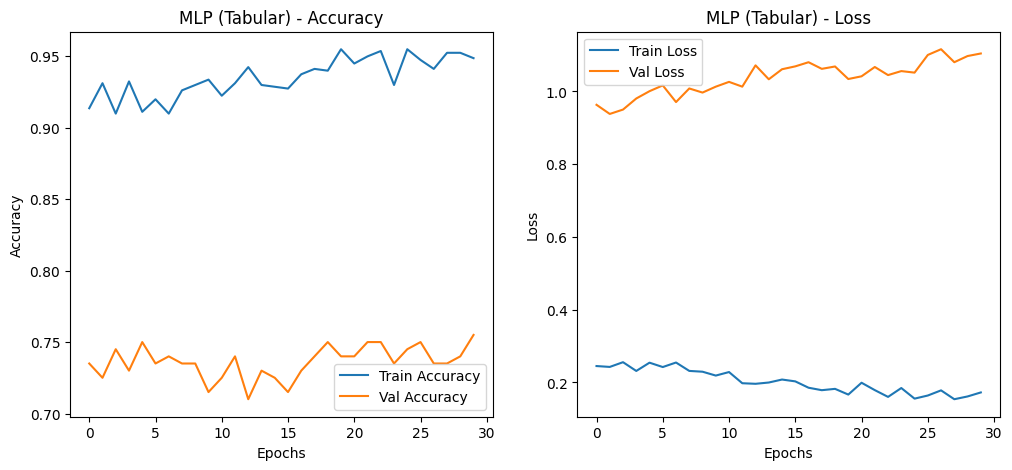

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


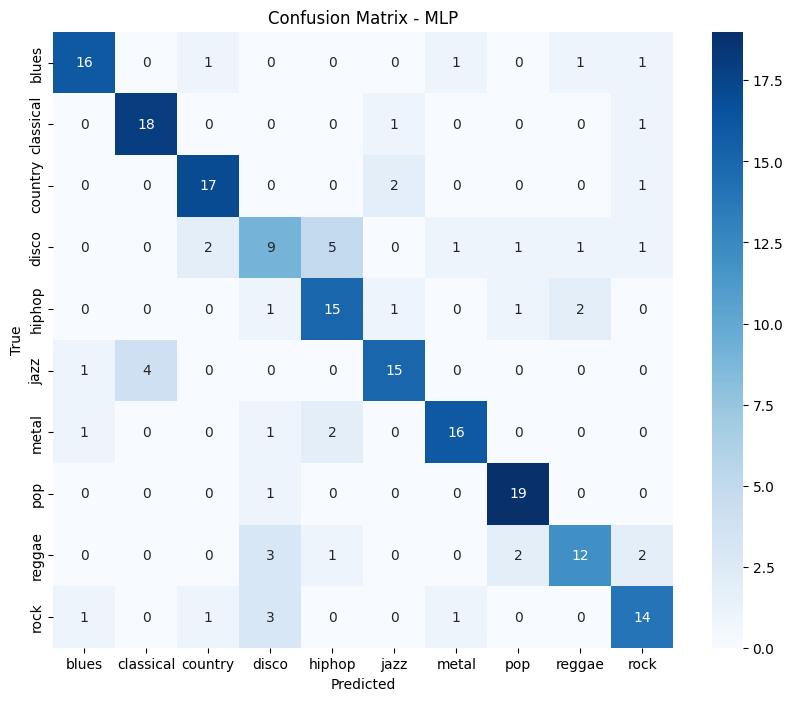

In [18]:
# MLP Model Graphs
# ==============================
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
plot_history(mlp_history, "MLP (Tabular)")

# Confusion Matrix (MLP)
mlp_preds = np.argmax(mlp_model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
# STEP 5: Convert Audio → Spectrograms
# =====================================
IMG_SIZE = 128
SPEC_DIR = "spectrograms"
os.makedirs(SPEC_DIR, exist_ok=True)

def audio_to_mel_spectrogram(file_path, save_path):
    import matplotlib.pyplot as plt # Import plt inside the function
    fig = None  # Initialize fig to None
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        fig = plt.figure(figsize=(1.28,1.28), dpi=100)
        librosa.display.specshow(mel_spec_db, sr=sr)
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except Exception as e:
        print(f"Error converting {file_path} to spectrogram: {e}. Skipping file.")
        if fig is not None: # Only close fig if it was created
            plt.close(fig)


# Check if genres and AUDIO_DIR are defined
if 'genres' in locals() and 'AUDIO_DIR' in locals():
    for genre in genres:
        genre_path = os.path.join(AUDIO_DIR, genre)
        save_folder = os.path.join(SPEC_DIR, genre)
        os.makedirs(save_folder, exist_ok=True)
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            save_path = os.path.join(save_folder, file.replace(".wav", ".png"))
            if not os.path.exists(save_path):
                audio_to_mel_spectrogram(file_path, save_path)
else:
    print("Please ensure 'genres' and 'AUDIO_DIR' variables are defined by running the previous cells.")

/tmp/ipython-input-2855910358.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error converting gtzan_dataset/Data/genres_original/jazz/jazz.00054.wav to spectrogram: . Skipping file.


In [26]:
# STEP 6: CNN Model on Spectrograms
# =====================================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    SPEC_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='categorical', subset='training')

val_gen = datagen.flow_from_directory(
    SPEC_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='categorical', subset='validation')

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(genres), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_model.fit(train_gen, epochs=20, validation_data=val_gen)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1136 - loss: 2.3388 - val_accuracy: 0.1106 - val_loss: 2.2004
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2106 - loss: 2.1632 - val_accuracy: 0.2663 - val_loss: 1.9678
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3092 - loss: 1.9126 - val_accuracy: 0.3920 - val_loss: 1.8411
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4032 - loss: 1.6852 - val_accuracy: 0.3970 - val_loss: 1.8823
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4237 - loss: 1.5914 - val_accuracy: 0.3920 - val_loss: 1.6804
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5009 - loss: 1.3820 - val_accuracy: 0.3869 - val_loss: 1.7593
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5049 - loss: 1.4169 - val_accuracy: 0.3819 - val_loss: 1.6670
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5145 - loss: 1.3105 - val_accuracy: 0.4422 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step


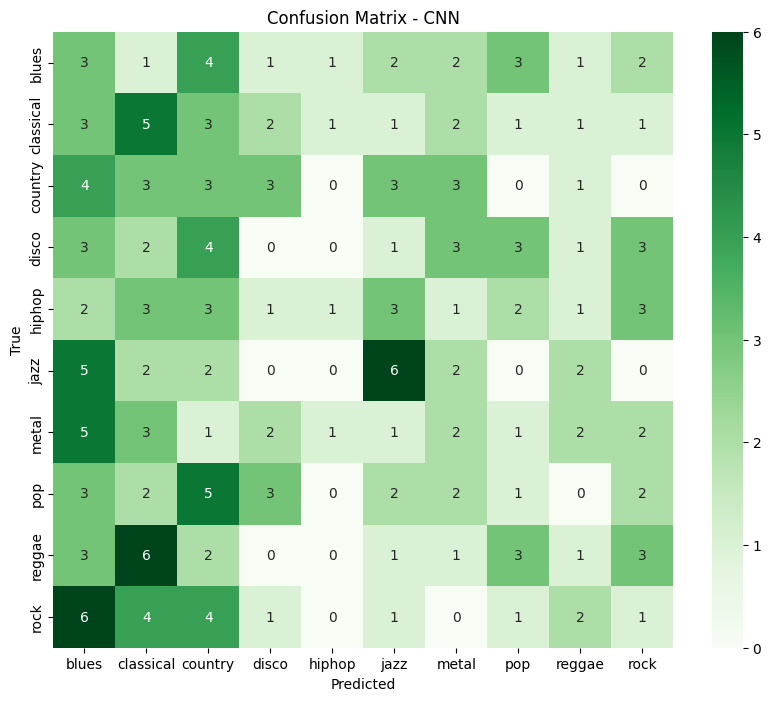

In [30]:
# Confusion Matrix - CNN
val_gen.reset()
cnn_preds = cnn_model.predict(val_gen)
cnn_preds = np.argmax(cnn_preds, axis=1)
true_labels = val_gen.classes

cm = confusion_matrix(true_labels, cnn_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=list(val_gen.class_indices.keys()),
            yticklabels=list(val_gen.class_indices.keys()))
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()